## Importing libraries and loading data

In [1]:
import numpy as np
import pandas as pd
import os
import statsmodels.formula.api as smf
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')

In [2]:
click = pd.read_csv("JD_click_data.csv")
order = pd.read_csv("JD_order_data.csv")
sku = pd.read_csv("JD_sku_data.csv")
user = pd.read_csv("JD_user_data.csv")

## Data preprocessing

### creating a feature base on how many times a sku is clicked

In [3]:
click_count = click.groupby('sku_ID').size().reset_index(name='click_count_on_sku')
click_and_count = pd.merge(click,click_count,on='sku_ID')
print(click_and_count.shape)
click_and_count.head()

(20214515, 5)


,sku_ID,user_ID,request_time,channel,click_count_on_sku
0,a234e08c57,4c3d6d10c2,2018-03-01 23:57:53,wechat,624
1,a234e08c57,405246945e,2018-03-01 10:10:03,pc,624
2,a234e08c57,405246945e,2018-03-01 09:47:16,pc,624
3,a234e08c57,cb47a16a92,2018-03-01 09:39:32,pc,624
4,a234e08c57,34e76b1af1,2018-03-01 12:18:01,app,624


### creating a feature base on how many skus are in each brand id

In [4]:
sku=sku.drop(columns=["attribute1","attribute2","activate_date","deactivate_date"])
brand_count = sku.groupby('brand_ID').size().reset_index(name='sku_count_on_brand')
sku_and_brand_count = pd.merge(sku,brand_count,on='brand_ID')
print(sku_and_brand_count.shape)
sku_and_brand_count.head()

(31868, 4)


,sku_ID,type,brand_ID,sku_count_on_brand
0,a234e08c57,1,c3ab4bf4d9,4
1,9f785be866,1,c3ab4bf4d9,4
2,b6866bf66f,1,c3ab4bf4d9,4
3,0be89cc509,1,c3ab4bf4d9,4
4,6449e1fd87,1,1d8b4b4c63,26


### merging click count and sku count in each brand

In [5]:
click_and_sku = pd.merge(click_and_count,sku_and_brand_count,on='sku_ID')
print(click_and_sku.shape)
click_and_sku.head()

(20214548, 8)


,sku_ID,user_ID,request_time,channel,click_count_on_sku,type,brand_ID,sku_count_on_brand
0,a234e08c57,4c3d6d10c2,2018-03-01 23:57:53,wechat,624,1,c3ab4bf4d9,4
1,a234e08c57,405246945e,2018-03-01 10:10:03,pc,624,1,c3ab4bf4d9,4
2,a234e08c57,405246945e,2018-03-01 09:47:16,pc,624,1,c3ab4bf4d9,4
3,a234e08c57,cb47a16a92,2018-03-01 09:39:32,pc,624,1,c3ab4bf4d9,4
4,a234e08c57,34e76b1af1,2018-03-01 12:18:01,app,624,1,c3ab4bf4d9,4


### clearing up order data and user data, then merging them together

In [6]:
print(order.shape)
print(user.shape)
order = order.drop(columns=["order_ID","order_date","order_time","quantity","type",
                            "promise","direct_discount_per_unit","quantity_discount_per_unit",
                            "bundle_discount_per_unit","coupon_discount_per_unit","gift_item",
                            "dc_ori","dc_des"])
order = order.assign(discount=order['original_unit_price'] - order['final_unit_price'])
order = order.drop(columns=["original_unit_price"])
print(order.shape)
order.head()

(549989, 17)
(457298, 10)
(549989, 4)


,user_ID,sku_ID,final_unit_price,discount
0,0abe9ef2ce,581d5b54c1,79.0,10.0
1,33a9e56257,067b673f2b,53.9,46.0
2,4ea3cf408f,623d0a582a,58.5,19.5
3,b87cb736cb,fc5289b139,35.0,26.0
4,4829223b6f,623d0a582a,53.0,25.0


In [7]:
user = user.drop(columns=["plus"])
order_and_user = pd.merge(order,user,on="user_ID",how='left')
print(order_and_user.info())
order_and_user.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549989 entries, 0 to 549988
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_ID            549989 non-null  object 
 1   sku_ID             549989 non-null  object 
 2   final_unit_price   549989 non-null  float64
 3   discount           549989 non-null  float64
 4   user_level         549989 non-null  int64  
 5   first_order_month  549989 non-null  object 
 6   gender             549989 non-null  object 
 7   age                549989 non-null  object 
 8   marital_status     549989 non-null  object 
 9   education          549989 non-null  int64  
 10  city_level         549989 non-null  int64  
 11  purchase_power     549989 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 54.5+ MB
None


,user_ID,sku_ID,final_unit_price,discount,user_level,first_order_month,gender,age,marital_status,education,city_level,purchase_power
0,0abe9ef2ce,581d5b54c1,79.0,10.0,1,2013-06,F,36-45,M,3,2,2
1,33a9e56257,067b673f2b,53.9,46.0,1,2016-05,F,26-35,S,2,2,3
2,4ea3cf408f,623d0a582a,58.5,19.5,2,2013-02,F,16-25,S,2,2,2
3,b87cb736cb,fc5289b139,35.0,26.0,3,2014-08,F,26-35,M,3,2,2
4,4829223b6f,623d0a582a,53.0,25.0,1,2014-10,F,26-35,M,2,2,4


In [8]:
print(order_and_user.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549989 entries, 0 to 549988
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_ID            549989 non-null  object 
 1   sku_ID             549989 non-null  object 
 2   final_unit_price   549989 non-null  float64
 3   discount           549989 non-null  float64
 4   user_level         549989 non-null  int64  
 5   first_order_month  549989 non-null  object 
 6   gender             549989 non-null  object 
 7   age                549989 non-null  object 
 8   marital_status     549989 non-null  object 
 9   education          549989 non-null  int64  
 10  city_level         549989 non-null  int64  
 11  purchase_power     549989 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 54.5+ MB
None


### filering out the top 5 brand based on click count

In [9]:
click_and_sku_sum = click_and_sku.groupby('brand_ID')['click_count_on_sku'].sum().reset_index()
sorted_click_and_sku = click_and_sku_sum.sort_values(by='click_count_on_sku', ascending=False)
sorted_click_and_sku = sorted_click_and_sku.drop_duplicates('brand_ID')
sorted_click_and_sku.head()

,brand_ID,click_count_on_sku
1148,99d41501ff,914750382067
1158,9b0d3a5fc6,325725178406
482,43999af013,188366065478
647,5ab8ea8556,167247986280
436,3daeabd2ce,108479659167


In [10]:
top_five_brand = sorted_click_and_sku.iloc[:5]['brand_ID']
print(top_five_brand.shape)
top_five_brand.head()

(5,)


1148    99d41501ff
1158    9b0d3a5fc6
482     43999af013
647     5ab8ea8556
436     3daeabd2ce
Name: brand_ID, dtype: object

### filtering out customers who has clicked the top 5 brands

In [11]:
brand_users = click_and_sku[click_and_sku['brand_ID'].isin(top_five_brand)]
brand_users = brand_users.drop(brand_users[brand_users['user_ID'] == '-'].index)
brand_users = brand_users.drop_duplicates('user_ID')
print(brand_users.shape)
brand_users.head()

(1092105, 8)


,sku_ID,user_ID,request_time,channel,click_count_on_sku,type,brand_ID,sku_count_on_brand
6291,acad9fed04,8f10d63196,2018-03-01 13:40:19,wechat,5298,2,9b0d3a5fc6,831
6292,acad9fed04,9d4b9e82d1,2018-03-01 18:51:20,wechat,5298,2,9b0d3a5fc6,831
6296,acad9fed04,c87110cc99,2018-03-01 21:27:46,mobile,5298,2,9b0d3a5fc6,831
6297,acad9fed04,06a3e9a8ca,2018-03-01 22:12:32,mobile,5298,2,9b0d3a5fc6,831
6300,acad9fed04,2068e97a97,2018-03-01 20:00:56,app,5298,2,9b0d3a5fc6,831


In [12]:
user_ids = brand_users['user_ID']
user_ids.head()

6291    8f10d63196
6292    9d4b9e82d1
6296    c87110cc99
6297    06a3e9a8ca
6300    2068e97a97
Name: user_ID, dtype: object

In [13]:
top_five_brand_user = order_and_user[order_and_user['user_ID'].isin(user_ids)]
print(top_five_brand_user.shape)
top_five_brand_user.head()

(267022, 12)


,user_ID,sku_ID,final_unit_price,discount,user_level,first_order_month,gender,age,marital_status,education,city_level,purchase_power
1,33a9e56257,067b673f2b,53.9,46.0,1,2016-05,F,26-35,S,2,2,3
4,4829223b6f,623d0a582a,53.0,25.0,1,2014-10,F,26-35,M,2,2,4
5,0b07cae293,589c2b865b,38.9,41.0,2,2015-11,F,16-25,S,3,2,2
7,d5e8910932,d829f03a28,40.9,39.0,2,2017-07,F,16-25,S,3,2,2
8,d5e8910932,5f58bfd286,37.9,42.0,2,2017-07,F,16-25,S,3,2,2


### dropping cols

In [14]:
data = top_five_brand_user
data = data.drop(columns=["first_order_month","sku_ID"])

## EDA

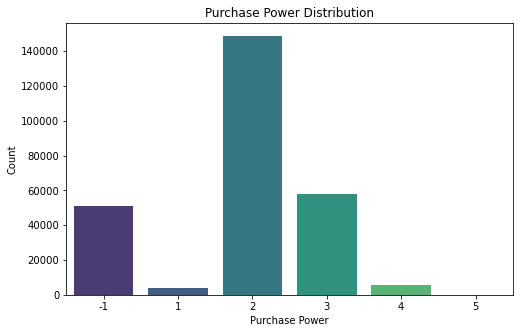

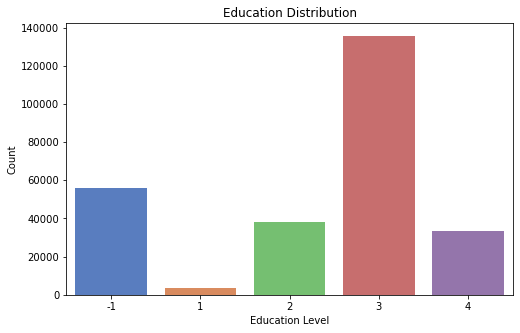

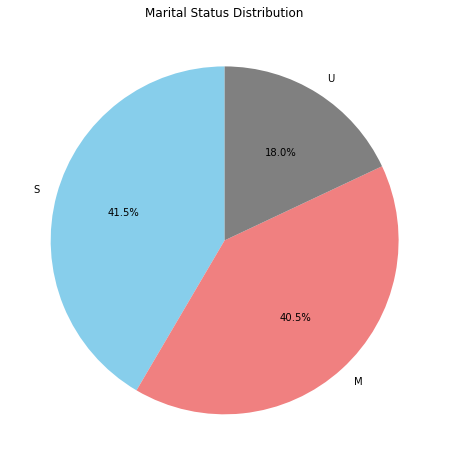

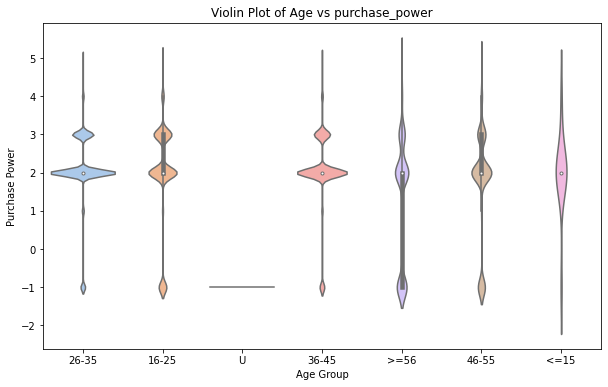

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chart 1: Bar chart of purchase_power distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='purchase_power', data=data, palette='viridis')
plt.title('Purchase Power Distribution')
plt.xlabel('Purchase Power')
plt.ylabel('Count')
plt.show()

# Chart 2: Bar chart of education distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='education', data=data, palette='muted')
plt.title('Education Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

# Chart 3: Pie chart of marital_status
# Count the occurrences of each marital status
marital_status_counts = data['marital_status'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'grey'])
plt.title('Marital Status Distribution')
plt.show()

# Chart 4: Violin plot for the distribution of age
plt.figure(figsize=(10, 6))
sns.violinplot(x='age', y='purchase_power', data=data, palette='pastel')
plt.title('Violin Plot of Age vs purchase_power')
plt.xlabel('Age Group')
plt.ylabel('Purchase Power')
plt.show()


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267022 entries, 1 to 549988
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_ID           267022 non-null  object 
 1   final_unit_price  267022 non-null  float64
 2   discount          267022 non-null  float64
 3   user_level        267022 non-null  int64  
 4   gender            267022 non-null  object 
 5   age               267022 non-null  object 
 6   marital_status    267022 non-null  object 
 7   education         267022 non-null  int64  
 8   city_level        267022 non-null  int64  
 9   purchase_power    267022 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 32.4+ MB


## Data Preprocessing for model

### one-hot encoding

In [17]:
print(sorted(pd.unique(data['gender'])))
print(sorted(pd.unique(data['age'])))
print(sorted(pd.unique(data['marital_status'])))
data['gender'].replace(['F', 'M', 'U'],[2,1,0],inplace=True)
data['age'].replace(['16-25', '26-35', '36-45', '46-55', '<=15', '>=56', 'U'],[2,3,4,5,1,6,0],inplace=True)
data['marital_status'].replace(['M', 'S', 'U'],[2,1,0],inplace=True)

['F', 'M', 'U']
['16-25', '26-35', '36-45', '46-55', '<=15', '>=56', 'U']
['M', 'S', 'U']


In [18]:
data = pd.get_dummies(data, columns = ['user_level', 'gender', 'age', 'marital_status', 'education', 'city_level'])

In [19]:
data['purchase_power'] = data['purchase_power'].astype('category')

### dropping missing values

In [20]:
any_missing = data.isnull().values.any()
print(f"{any_missing}")

False


In [21]:
len(data)

267022

In [22]:
data.head()

,user_ID,final_unit_price,discount,purchase_power,user_level_-1,user_level_0,user_level_1,user_level_2,user_level_3,user_level_4,...,education_1,education_2,education_3,education_4,city_level_-1,city_level_1,city_level_2,city_level_3,city_level_4,city_level_5
1,33a9e56257,53.9,46.0,3,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,4829223b6f,53.0,25.0,4,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
5,0b07cae293,38.9,41.0,2,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
7,d5e8910932,40.9,39.0,2,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
8,d5e8910932,37.9,42.0,2,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0


## Data split

In [23]:
X = data.drop(['purchase_power','user_ID','discount','final_unit_price'],axis=1)
y = data['purchase_power']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=88)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186915 entries, 291962 to 212029
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   user_level_-1     186915 non-null  uint8
 1   user_level_0      186915 non-null  uint8
 2   user_level_1      186915 non-null  uint8
 3   user_level_2      186915 non-null  uint8
 4   user_level_3      186915 non-null  uint8
 5   user_level_4      186915 non-null  uint8
 6   user_level_10     186915 non-null  uint8
 7   gender_0          186915 non-null  uint8
 8   gender_1          186915 non-null  uint8
 9   gender_2          186915 non-null  uint8
 10  age_0             186915 non-null  uint8
 11  age_1             186915 non-null  uint8
 12  age_2             186915 non-null  uint8
 13  age_3             186915 non-null  uint8
 14  age_4             186915 non-null  uint8
 15  age_5             186915 non-null  uint8
 16  age_6             186915 non-null  uint8
 17  marit

In [25]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80107 entries, 257672 to 388291
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   user_level_-1     80107 non-null  uint8
 1   user_level_0      80107 non-null  uint8
 2   user_level_1      80107 non-null  uint8
 3   user_level_2      80107 non-null  uint8
 4   user_level_3      80107 non-null  uint8
 5   user_level_4      80107 non-null  uint8
 6   user_level_10     80107 non-null  uint8
 7   gender_0          80107 non-null  uint8
 8   gender_1          80107 non-null  uint8
 9   gender_2          80107 non-null  uint8
 10  age_0             80107 non-null  uint8
 11  age_1             80107 non-null  uint8
 12  age_2             80107 non-null  uint8
 13  age_3             80107 non-null  uint8
 14  age_4             80107 non-null  uint8
 15  age_5             80107 non-null  uint8
 16  age_6             80107 non-null  uint8
 17  marital_status_0  80107 n

## Model

### evaulation

In [26]:
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


logreg = LogisticRegression(random_state=600,solver='newton-cg')
logreg.fit(X_train,y_train)

predictions = logreg.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

          -1       0.98      0.96      0.97     15332
           1       0.00      0.00      0.00      1215
           2       0.74      0.92      0.82     44382
           3       0.51      0.28      0.36     17465
           4       0.58      0.01      0.01      1694
           5       0.00      0.00      0.00        19

    accuracy                           0.76     80107
   macro avg       0.47      0.36      0.36     80107
weighted avg       0.72      0.76      0.72     80107

[[14697     0   388   247     0     0]
 [    1     0  1140    74     0     0]
 [   52     0 41011  3316     3     0]
 [  169     0 12360  4931     5     0]
 [  100     0   516  1067    11     0]
 [    1     0     4    14     0     0]]


In [28]:
y_hat_test = logreg.predict(X_test)
y_hat_test

array([ 2,  2,  2, ...,  2, -1,  2])

In [29]:
y_train

291962   -1
491443    1
548657   -1
51258    -1
539320    3
         ..
497715    2
405316    4
182181   -1
274818    4
212029    2
Name: purchase_power, Length: 186915, dtype: category
Categories (6, int64): [-1, 1, 2, 3, 4, 5]

### Random Forest

In [30]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import feature_selection
import time

In [32]:
rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, 
                           n_estimators = 500, random_state=333, verbose=2)
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=333, verbose=2)

In [33]:
grid_values = {'max_features': np.linspace(1,15,5, dtype='int32'),
               'max_depth': [2,3,4,5,6],
               'min_samples_leaf': [5],
               'n_estimators': [100],
               'random_state': [88]} 

rf2 = RandomForestClassifier()

cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2',cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88 
[CV]  max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88, total=   2.7s
[CV] max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88, total=   2.8s
[CV] max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88 
[CV]  max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88, total=   2.7s
[CV] max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88 
[CV]  max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88, total=   2.7s
[CV] max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88 
[CV]  max_depth=2, max_features=1, min_samples_leaf=5, n_estimators=100, random_state=88, total=   2.7s
[CV] max_depth=2, max_features=4, min_samples_leaf=5, n_estimators=100, random_state=88 
[CV]  max_depth=2, max_features=4, min_samples_leaf=5, n_estimators=100, random_state=88, total=   3.2s
[CV] max_depth=2, max_features=4, min_samples_leaf=5, n_estimators=100, random_state=88 
[CV]  max_depth=2, max_features=4, 

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 13.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=333, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_features': array([ 1,  4,  8, 11, 15], dtype=int32),
                         'min_samples_leaf': [5], 'n_estimators': [100],
                         'random_state': [88]},
             scoring='r2', verbose=2)

In [34]:
print('Best parameters', rf_cv.best_params_)

Best parameters {'max_depth': 2, 'max_features': 11, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 88}


In [35]:
print('Cross-validated R2:', round(rf_cv.best_score_, 5))

Cross-validated R2: 0.79043


In [36]:
rf_best = rf_cv.best_estimator_
rf_best.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 4.12793092e-02, 3.08802177e-04,
       5.96952960e-04, 1.77761276e-02, 0.00000000e+00, 1.25842305e-01,
       4.95525712e-04, 0.00000000e+00, 5.06425820e-02, 0.00000000e+00,
       4.66372707e-04, 1.16091626e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.39180542e-01, 1.74631315e-02, 9.27960501e-03,
       2.76824857e-01, 0.00000000e+00, 7.75907917e-04, 1.10848013e-02,
       4.05417133e-03, 3.81275791e-03, 0.00000000e+00, 1.39524355e-07,
       0.00000000e+00, 1.71091567e-08, 0.00000000e+00])

In [37]:
imp_df = pd.DataFrame({
    'Varname': X_train.columns,
    'imp': rf_best.feature_importances_
})

imp_df.sort_values(by='imp', ascending=False)

,Varname,imp
17,marital_status_0,4.391805e-01
20,education_-1,2.768249e-01
7,gender_0,1.258423e-01
10,age_0,5.064258e-02
2,user_level_1,4.127931e-02
5,user_level_4,1.777613e-02
18,marital_status_1,1.746313e-02
23,education_3,1.108480e-02
19,marital_status_2,9.279605e-03
24,education_4,4.054171e-03


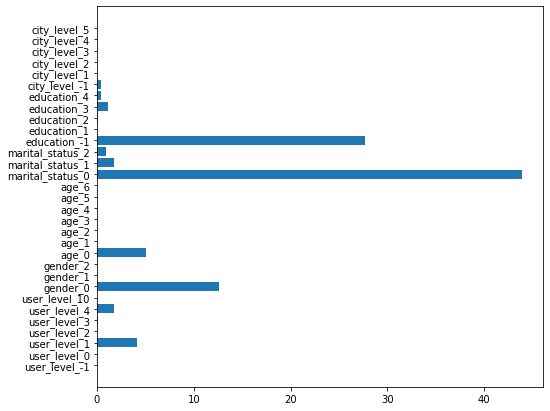

In [38]:
plt.figure(figsize=(8,7))
plt.barh(X_train.columns, 100*rf_cv.best_estimator_.feature_importances_)
plt.show()

### CART

In [39]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_features='auto')
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
print('Precision:',precision_score(y_test, y_pred, average='weighted'))
print('Recall:',recall_score(y_test, y_pred, average='weighted'))

Confusion Matrix : 
 [[14767     0   389   169     7     0]
 [    1     6  1130    78     0     0]
 [   82    20 41081  3182    17     0]
 [  223     5 12446  4716    75     0]
 [  135     1   518   983    57     0]
 [    1     0     2    15     1     0]]
Precision: 0.7184170894282075
Recall: 0.7568252462331632


### With crosss validation 

In [40]:
grid_values = {'ccp_alpha': np.linspace(0.001, 0.2, 201),# the choice of alpha, ranging from 0 to 0.2
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

            
dtc = DecisionTreeClassifier()

cv = KFold(n_splits=5,random_state=1,shuffle=True) 

dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=cv, verbose=1) 
dtc_cv_acc.fit(X_train, y_train)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1005 out of 1005 | elapsed:  8.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.001   , 0.001995, 0.00299 , 0.003985, 0.00498 , 0.005975,
       0.00697 , 0.007965, 0.00896 , 0.009955, 0.01095 , 0.011945,
       0.01294 , 0.013935, 0.01493 , 0.015925, 0.01692 , 0.017915,
       0.01891 , 0.019905, 0.0209  , 0.021895, 0.02289 , 0.023885,
       0.02488 , 0.025875, 0.02...
       0.16816 , 0.169155, 0.17015 , 0.171145, 0.17214 , 0.173135,
       0.17413 , 0.175125, 0.17612 , 0.177115, 0.17811 , 0.179105,
       0.1801  , 0.181095, 0.18209 , 0.183085, 0.18408 , 0.185075,
       0.18607 , 0.187065, 0.18806 , 0.189055, 0.19005 , 0.191045,
       0.19204 , 0.193035, 0.19403 , 0.195025, 0.19602 , 0.197015,
       0.19801 , 0.199005, 0.2     ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accur

In [41]:
acc = dtc_cv_acc.cv_results_['mean_test_score'] 
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc}).head(20)

,ccp alpha,Validation Accuracy
0,0.001,0.755049
1,0.001995,0.755049
2,0.00299,0.754402
3,0.003985,0.752021
4,0.00498,0.752021
5,0.005975,0.752021
6,0.00697,0.752021
7,0.007965,0.752021
8,0.00896,0.752021
9,0.009955,0.752021


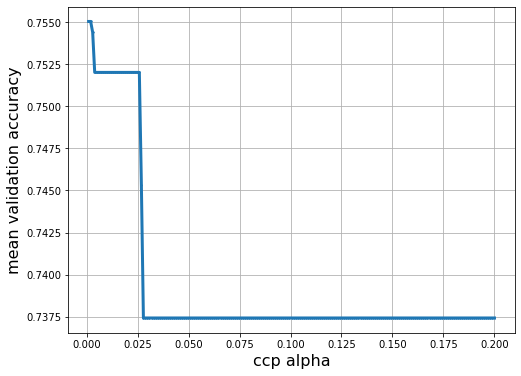

In [42]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [43]:
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.001
Grid best score (accuracy):  0.7550490864831609


### Boosting

In [44]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)
bt_model = ada.fit(X_train, y_train)

In [45]:
y_pred1 = bt_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))


Accuracy: 0.7466638371178549


### With Cross Validation

In [46]:
grid_values = {'learning_rate': [0.1*i for i in range(1,10)],
               'n_estimators': [100],
               'random_state': [88]} 

tic = time.time()

bt2 = AdaBoostClassifier() 

cv = KFold(n_splits=5,random_state=88,shuffle=True) 
bt2_cv = GridSearchCV(bt2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
bt2_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] learning_rate=0.1, n_estimators=100, random_state=88 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, n_estimators=100, random_state=88, total=  13.1s
[CV] learning_rate=0.1, n_estimators=100, random_state=88 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s


[CV]  learning_rate=0.1, n_estimators=100, random_state=88, total=  12.4s
[CV] learning_rate=0.1, n_estimators=100, random_state=88 ............
[CV]  learning_rate=0.1, n_estimators=100, random_state=88, total=  12.9s
[CV] learning_rate=0.1, n_estimators=100, random_state=88 ............
[CV]  learning_rate=0.1, n_estimators=100, random_state=88, total=  12.9s
[CV] learning_rate=0.1, n_estimators=100, random_state=88 ............
[CV]  learning_rate=0.1, n_estimators=100, random_state=88, total=  11.5s
[CV] learning_rate=0.2, n_estimators=100, random_state=88 ............
[CV]  learning_rate=0.2, n_estimators=100, random_state=88, total=  12.0s
[CV] learning_rate=0.2, n_estimators=100, random_state=88 ............
[CV]  learning_rate=0.2, n_estimators=100, random_state=88, total=  11.7s
[CV] learning_rate=0.2, n_estimators=100, random_state=88 ............
[CV]  learning_rate=0.2, n_estimators=100, random_state=88, total=  11.6s
[CV] learning_rate=0.2, n_estimators=100, random_state=8

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  8.8min finished


time: 542.17 s


In [47]:
print(bt2_cv.best_params_)
y_test_pred = bt2_cv.best_estimator_.predict(X_test)

print('Precision:',precision_score(y_test, y_test_pred, average='weighted'))
print('Recall:',recall_score(y_test, y_test_pred, average='weighted'))

{'learning_rate': 0.2, 'n_estimators': 100, 'random_state': 88}
Precision: 0.7074185670262768
Recall: 0.7547655011422223


In [48]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.7547655011422223
